#### TensorFlow

In [1]:
#import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list

# Parameter
n_step = 5  # maxium number of words in one sentence(=number of time steps)
n_hidden = 128

W0603 21:21:49.729893 23768 __init__.py:308] Limited tf.compat.v2.summary API due to missing TensorBoard installation.


In [2]:
#methods
def make_batch(sentences):
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]
    return input_batch, output_batch, target_batch

# Model
enc_inputs = tf.placeholder(tf.float32, [None, None, n_class])  # [batch_size, n_step, n_class]
dec_inputs = tf.placeholder(tf.float32, [None, None, n_class])  # [batch_size, n_step, n_class]
targets = tf.placeholder(tf.int64, [1, n_step])  # [batch_size, n_step], not one-hot

# Linear for attention
attn = tf.Variable(tf.random_normal([n_hidden, n_hidden]))
out = tf.Variable(tf.random_normal([n_hidden * 2, n_class]))

def get_att_score(dec_output, enc_output):  # enc_output [n_step, n_hidden]
    score = tf.squeeze(tf.matmul(enc_output, attn), 0)  # score : [n_hidden]
    dec_output = tf.squeeze(dec_output, [0, 1])  # dec_output : [n_hidden]
    return tf.tensordot(dec_output, score, 1)  # inner product make scalar value

def get_att_weight(dec_output, enc_outputs):
    attn_scores = []  # list of attention scalar : [n_step]
    enc_outputs = tf.transpose(enc_outputs, [1, 0, 2])  # enc_outputs : [n_step, batch_size, n_hidden]
    for i in range(n_step):
        attn_scores.append(get_att_score(dec_output, enc_outputs[i]))

    # Normalize scores to weights in range 0 to 1
    return tf.reshape(tf.nn.softmax(attn_scores), [1, 1, -1])  # [1, 1, n_step]

In [3]:
model = []
Attention = []
with tf.variable_scope('encode'):
    enc_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)
    # enc_outputs : [batch_size(=1), n_step(=decoder_step), n_hidden(=128)]
    # enc_hidden : [batch_size(=1), n_hidden(=128)]
    enc_outputs, enc_hidden = tf.nn.dynamic_rnn(enc_cell, enc_inputs, dtype=tf.float32)

with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.BasicRNNCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

    inputs = tf.transpose(dec_inputs, [1, 0, 2])
    hidden = enc_hidden
    for i in range(n_step):
        # time_major True mean inputs shape: [max_time, batch_size, ...]
        dec_output, hidden = tf.nn.dynamic_rnn(dec_cell, tf.expand_dims(inputs[i], 1),
                                               initial_state=hidden, dtype=tf.float32, time_major=True)
        attn_weights = get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
        Attention.append(tf.squeeze(attn_weights))

        # matrix-matrix product of matrices [1, 1, n_step] x [1, n_step, n_hidden] = [1, 1, n_hidden]
        context = tf.matmul(attn_weights, enc_outputs)
        dec_output = tf.squeeze(dec_output, 0)  # [1, n_step]
        context = tf.squeeze(context, 1)  # [1, n_hidden]

        model.append(tf.matmul(tf.concat((dec_output, context), 1), out))  # [n_step, batch_size(=1), n_class]

trained_attn = tf.stack([Attention[0], Attention[1], Attention[2], Attention[3], Attention[4]], 0)  # to show attention matrix
model = tf.transpose(model, [1, 0, 2])  # model : [n_step, n_class]
prediction = tf.argmax(model, 2)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

W0603 21:23:01.495906 23768 deprecation.py:323] From <ipython-input-3-156ebb6d752d>:4: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
W0603 21:23:01.513925 23768 deprecation.py:323] From <ipython-input-3-156ebb6d752d>:8: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0603 21:23:01.598778 23768 deprecation.py:506] From C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of pa

Epoch: 0400 cost = 0.000001
Epoch: 0800 cost = 0.000000
Epoch: 1200 cost = 0.000000
Epoch: 1600 cost = 0.000000
Epoch: 2000 cost = 0.001581
['ich', 'mochte', 'ein', 'bier', 'P'] -> ['i', 'want', 'a', 'beer', 'E']


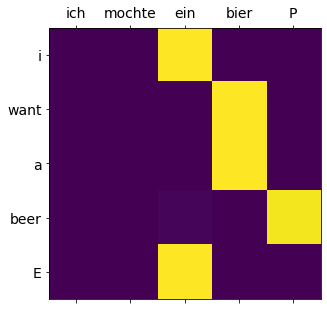

In [4]:
# Training and Test
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(2000):
        input_batch, output_batch, target_batch = make_batch(sentences)
        _, loss, attention = sess.run([optimizer, cost, trained_attn],
                                      feed_dict={enc_inputs: input_batch, dec_inputs: output_batch, targets: target_batch})

        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    predict_batch = [np.eye(n_class)[[word_dict[n] for n in 'P P P P P'.split()]]]
    result = sess.run(prediction, feed_dict={enc_inputs: input_batch, dec_inputs: predict_batch})
    print(sentences[0].split(), '->', [number_dict[n] for n in result[0]])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

#### PyTorch

In [5]:
#import
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list

# Parameter
n_hidden = 128

In [6]:
#method
def make_batch(sentences):
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return Variable(torch.Tensor(input_batch)), Variable(torch.Tensor(output_batch)), Variable(torch.LongTensor(target_batch))

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = Variable(torch.empty([n_step, 1, n_class]))

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = attn_weights.bmm(enc_outputs.transpose(0, 1))
            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = Variable(torch.zeros(n_step))  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0400 cost = 0.000484
Epoch: 0800 cost = 0.000152
Epoch: 1200 cost = 0.000074
Epoch: 1600 cost = 0.000043
Epoch: 2000 cost = 0.000028
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


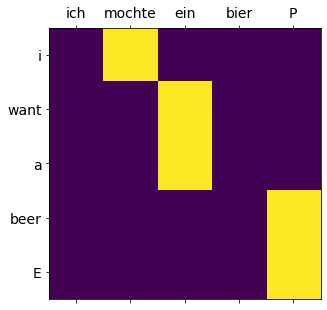

In [7]:
input_batch, output_batch, target_batch = make_batch(sentences)

# hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
hidden = Variable(torch.zeros(1, 1, n_hidden))

model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
for epoch in range(2000):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    if (epoch + 1) % 400 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Test
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
test_batch = Variable(torch.Tensor(test_batch))
predict, trained_attn = model(input_batch, hidden, test_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

# Show Attention
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(trained_attn, cmap='viridis')
ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
plt.show()